In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils, plot_model
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#from keras import backend as K
from keras.layers.core import K

%matplotlib inline

plt.rcParams['image.cmap'] = 'rainbow'

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
# Get input numpy arrays
inputs = {}
inputs['TT'] = glob.glob('inputdata/output_TT/*job1[1-3]*.npy')
inputs['QCD120'] = glob.glob('inputdata/output_QCD120/*job0*.npy')
inputs['QCD170'] = glob.glob('inputdata/output_QCD170/*job0*.npy')
inputs['QCD300'] = glob.glob('inputdata/output_QCD300/*job0*.npy')
inputs['QCD470'] = glob.glob('inputdata/output_QCD470/*job0*.npy')

list_params = {}
params = {}
for key, input_files in inputs.items():
    list_params[key] = []
    for in_file in input_files:
        try:
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print('bad file: {:s}'.format(in_file))
    params[key] = np.concatenate(list_params[key])
# Print out variables in the data
print(params['TT'].dtype)

[('run', '<i4'), ('lumi', '<i4'), ('event', '<i4'), ('met', '<f8'), ('sumet', '<f8'), ('rho', '<f8'), ('pthat', '<f8'), ('mcweight', '<f8'), ('njet_ak7', '<i4'), ('jet_pt_ak7', '<f8'), ('jet_eta_ak7', '<f8'), ('jet_phi_ak7', '<f8'), ('jet_E_ak7', '<f8'), ('jet_msd_ak7', '<f8'), ('jet_area_ak7', '<f8'), ('jet_jes_ak7', '<f8'), ('jet_tau21_ak7', '<f8'), ('jet_isW_ak7', '<i4'), ('jet_ncand_ak7', '<i4'), ('ak7pfcand_pt', '<f8'), ('ak7pfcand_eta', '<f8'), ('ak7pfcand_phi', '<f8'), ('ak7pfcand_id', '<i4'), ('ak7pfcand_charge', '<i4'), ('ak7pfcand_ijet', '<i4')]


In [3]:
# Now let's prepare some jet images
df_dict_jet = {}
df_dict_cand = {}

# This is a classification problem where we have two categories.
# Let's call them signal (label as 1) and background (label as 0).
# The signal can be extracted from datasets named "TT", i.e., the object that is a 'W' (jet_isW_ak7==1). Then the background come from datasets named "QCD*".
# There are 4 of them for the background datasets as in the list_QCD.
list_QCD = ['QCD120','QCD170','QCD300','QCD470']

# For each event, we can have mutiple jets, so the jet columns selections include event-wide variables
# For each jet, we have multiple particle candidates (cand). Each jet has a cone of radius 0.7 and can contain multiple
# candidates. Therefore we keep candidate level information, i.e., the ak7pfcand_*.
columns_jet = ['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','ak7pfcand_ijet']
columns_cand = ['event', 'jet_pt_ak7', 'jet_isW_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet']

df_dict_jet['TT'] = pd.DataFrame(params['TT'],columns=columns_jet)
# Since each entry contains a pfcand and each event can have multiple pfcand, for event-wise dataframe, there are duplicates.
# Therefore a drop_duplicates() is necessary.
df_dict_jet['TT'] = df_dict_jet['TT'].drop_duplicates()
df_dict_cand['TT'] = pd.DataFrame(params['TT'],columns=columns_cand)

for QCDbin in list_QCD:
    df_dict_jet[QCDbin] = pd.DataFrame(params[QCDbin],columns=columns_jet)
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].drop_duplicates()
    # Take every 8th jet just to make the training faster and have a sample roughly the size of W jets
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].iloc[::8, :]
    
    df_dict_cand[QCDbin] = pd.DataFrame(params[QCDbin],columns=columns_cand)

# Create a map of 'QCD' which is a sum of the individual QCD datasets
df_dict_jet['QCD'] = pd.concat([df_dict_jet[x] for x in list_QCD])
df_dict_cand['QCD'] = pd.concat([df_dict_cand[x] for x in list_QCD])

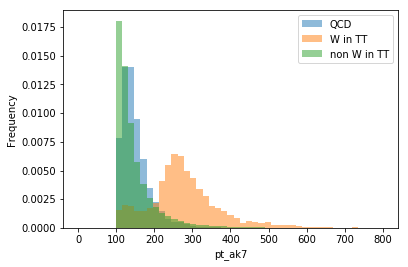

In [4]:
# Plot an important variable to find its range between signal ('W in TT') and background (QCD)
_=plt.figure()
_=plt.xlabel('pt_ak7')
bins = np.linspace(0, 800, 50)
_=df_dict_jet['QCD']['jet_pt_ak7'].plot.hist(bins, alpha=0.5, label='QCD', weights=df_dict_jet['QCD']['mcweight'],normed=True)
_=df_dict_jet['TT'][df_dict_jet['TT'].jet_isW_ak7==1]['jet_pt_ak7'].plot.hist(bins, alpha=0.5, label='W in TT',normed=True)
_=df_dict_jet['TT'][df_dict_jet['TT'].jet_isW_ak7==0]['jet_pt_ak7'].plot.hist(bins, alpha=0.5, label='non W in TT',normed=True)
_=plt.legend(loc='upper right')

In [5]:
# Select interesting events and separate out signal and background, i.e., via 'isW'e
# We can select events for training with specific "jet_pt_ak7" ranges. But here we use all of possible events. 
def selection_cuts(df, ptcuts, isW):
    return df[(df.jet_pt_ak7>ptcuts[0]) & (df.jet_pt_ak7<ptcuts[1]) & (df.jet_isW_ak7==isW)]

# The signals
df_dict_jet['TT'] = selection_cuts(df_dict_jet['TT'], (100., 1000.), 1)
df_dict_cand['TT'] = selection_cuts(df_dict_cand['TT'], (100., 1000.), 1)

# The backgrounds
for QCDbin in list_QCD:
    df_dict_jet[QCDbin] = selection_cuts(df_dict_jet[QCDbin], (100., 1000.), 0)
    df_dict_cand[QCDbin] = selection_cuts(df_dict_cand[QCDbin], (100., 1000.), 0)
    
df_dict_jet['QCD'] = selection_cuts(df_dict_jet['QCD'], (100., 1000.), 0)
df_dict_cand['QCD'] = selection_cuts(df_dict_cand['QCD'], (100.0, 1000.), 0)

print('number of events in TT : {}'.format(len(df_dict_jet['TT'])))
print('number of events in QCD : {}'.format(len(df_dict_jet['QCD'])))
print('number of candidates in TT : {}'.format(len(df_dict_cand['TT'])))
print('number of candidates in QCD : {}'.format(len(df_dict_cand['QCD'])))

number of events in TT : 3937
number of events in QCD : 9397
number of candidates in TT : 239137
number of candidates in QCD : 4000000


In [6]:
# Apply rotation + (possible) reflection needed later
def rotate_and_reflect(x,y,w):
    rot_x = []
    rot_y = []
    theta = 0
    maxPt = -1
    for ix, iy, iw in zip(x, y, w):
        dv = np.matrix([[ix],[iy]])-np.matrix([[x.iloc[0]],[y.iloc[0]]])
        dR = np.linalg.norm(dv)
        thisPt = iw
        if dR > 0.35 and thisPt > maxPt:
            maxPt = thisPt
            # rotation in eta-phi plane c.f  https://arxiv.org/abs/1407.5675 and https://arxiv.org/abs/1511.05190:
            # theta = -np.arctan2(iy,ix)-np.radians(90)
            # rotation by lorentz transformation c.f. https://arxiv.org/abs/1704.02124:
            px = iw * np.cos(iy)
            py = iw * np.sin(iy)
            pz = iw * np.sinh(ix)
            theta = np.arctan2(py,pz)+np.radians(90)
            
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    for ix, iy, iw in zip(x, y, w):
        # rotation in eta-phi plane:
        # rot = R*np.matrix([[ix],[iy]])
        # rix, riy = rot[0,0], rot[1,0]
        # rotation by lorentz transformation
        px = iw * np.cos(iy)
        py = iw * np.sin(iy)
        pz = iw * np.sinh(ix)
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        rot_x.append(rix)
        rot_y.append(riy)
        
    # Now reflect if leftSum > rightSum
    leftSum = 0
    rightSum = 0
    for ix, iy, iw in zip(x, y, w):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
    if leftSum > rightSum:
        ref_x = [-1.*rix for rix in rot_x]
        ref_y = rot_y
    else:
        ref_x = rot_x
        ref_y = rot_y
    
    return np.array(ref_x), np.array(ref_y)

In [7]:
# Function to fill the object images
def fill_jet_images(df_jet, df_cand, image_dims, rgb_dims):
    nx = image_dims[0]
    ny = image_dims[1]
    xbins = np.linspace(-1.4,1.4,image_dims[0]+1)
    ybins = np.linspace(-1.4,1.4,image_dims[1]+1)
    # Treat the charge of the particle candidate as an additional channel (analogy to the rgb channel in computer vision)
    if rgb_dims == 3:
        # Charges are within values of -1, 0 or 1
        charge_dims = (-1, 0, 1)
    else:
        charge_dims = (-99) 
    list_x = []
    list_y = []
    list_w = []
    njets = 0
    if K.image_dim_ordering() == 'tf':
        this_jet_images = np.zeros((len(df_jet), image_dims[0], image_dims[1], rgb_dims))
    else:
        this_jet_images = np.zeros((len(df_jet), rgb_dims, image_dims[0], image_dims[1]))
    # Loop over the jet objects
    for ij in range(len(df_jet)):
        njets += 1
        # Process the rgb channels
        for ic in range(rgb_dims):
            target_charge = charge_dims[ic]
            # Filter out rows with only target_charge. If it's -99, then no filtering.    
            if target_charge != -99:
                df_cand_tmp = df_cand[df_cand['ak7pfcand_charge']==target_charge]
            else:
                df_cand_tmp = df_cand
            # For each of the jet object, using 'ak7pfcand_ijet' to match and select all related particle candidates
            df_cand_ij = df_cand_tmp[(df_cand_tmp['ak7pfcand_ijet'] == df_jet['ak7pfcand_ijet'].iloc[ij]) & (df_cand_tmp['event']==df_jet['event'].iloc[ij])]
            # Normalize the jet image to be the first candidate coordiates
            x = df_cand_ij['ak7pfcand_eta'] - df_cand_ij['ak7pfcand_eta'].iloc[0]
            y = df_cand_ij['ak7pfcand_phi'] - df_cand_ij['ak7pfcand_phi'].iloc[0]
            # The weights (analogy to color channel intensity) are the transverse momentum of the candidates
            weights = df_cand_ij['ak7pfcand_pt']
            # Processing to compose a jet "image"
            x,y = rotate_and_reflect(x, y, weights)
            # Accumulate them all (later for plotting)
            list_x.append(x)
            list_y.append(y)
            list_w.append(weights)
            hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
            for ix in range(nx):
                for iy in range(ny):
                    # Fill the image to a numpy array
                    if K.image_dim_ordering() == 'tf':
                        this_jet_images[ij, ix, iy, ic] = hist[ix, iy]
                    else:
                        this_jet_images[ij, ic, ix, iy] = hist[ix, iy]
    return njets, list_x, list_y, list_w, this_jet_images

In [8]:
jet_images = {}
# 4D tensor
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is for channels (or rgb, etc.)

image_dims = (30, 30) # (nx, ny)
#image_dims = (15, 15) # (nx, ny)
rgb_dims = 3 # for charge (-1, 0, 1)

nx = image_dims[0]
ny = image_dims[1]
xbins = np.linspace(-1.4,1.4,image_dims[0]+1)
ybins = np.linspace(-1.4,1.4,image_dims[1]+1)

In [9]:
njets_TT, list_x_TT, list_y_TT, list_w_TT, this_jet_images_TT = fill_jet_images(df_dict_jet['TT'], df_dict_cand['TT'], image_dims, rgb_dims)
jet_images['TT'] = this_jet_images_TT
            
all_x_TT = np.concatenate(list_x_TT)
all_y_TT = np.concatenate(list_y_TT)
all_w_TT = np.concatenate(list_w_TT)
# Average the weights by total number of jet objects
all_w_TT = 1.*all_w_TT/njets_TT

njets_QCD, list_x_QCD, list_y_QCD, list_w_QCD, this_jet_images_QCD = fill_jet_images(df_dict_jet['QCD'], df_dict_cand['QCD'], image_dims, rgb_dims)
jet_images['QCD'] = this_jet_images_QCD
            
all_x_QCD = np.concatenate(list_x_QCD)
all_y_QCD = np.concatenate(list_y_QCD)
all_w_QCD = np.concatenate(list_w_QCD)
# Average the weights by total number of jet objects
all_w_QCD = 1.*all_w_QCD/njets_QCD

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arcsin
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


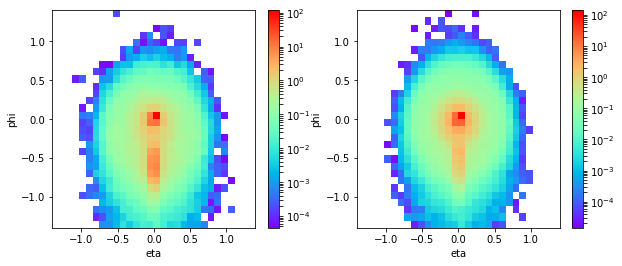

In [10]:
# Make jet image plots for signal ('W in TT') and background ('QCD') categories.
# They are average jet images over all the objects.
_=plt.figure(figsize=(10,4))

_=plt.subplot(1,2,1)
_=plt.hist2d(all_x_TT, all_y_TT, weights=all_w_TT, bins=(xbins,ybins), norm=mpl.colors.LogNorm(), label='W in TT')
_=plt.colorbar()
_=plt.xlabel('eta')
_=plt.ylabel('phi')

_=plt.subplot(1,2,2)
_=plt.hist2d(all_x_QCD, all_y_QCD, weights=all_w_QCD, bins=(xbins,ybins), norm=mpl.colors.LogNorm(), label='QCD')
_=plt.colorbar()
_=plt.xlabel('eta')
_=plt.ylabel('phi')
_=plt.show()

In [11]:
# Function to compose the Converlutional Neural Network model
def build_conv_model():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    model = Sequential()
    if K.image_dim_ordering()=='tf':
        input_shape = (nx, ny, rgb_dims)
    else:
        input_shape = (rgb_dims, nx, ny)
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))

    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.20))

    model.add(Flatten())
    model.add(Dropout(0.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.10))

    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])    
    return model
# Print out summary of the built model
conv_model = build_conv_model()
conv_model.summary()
#plot_model(conv_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 8)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 8)           584       
__________

In [12]:
# Prepare the input and output
X = np.concatenate([jet_images['TT'], jet_images['QCD']])
# For TT, it is in signal category, i.e., with label of 1.
# For QCD, it is in background category, i.e., with label of 0.
Y_TT = np.ones(jet_images['TT'].shape[0])
Y_QCD = np.zeros(jet_images['QCD'].shape[0])
Y = np.concatenate([Y_TT, Y_QCD])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y_trans = encoder.transform(Y)
# Transfer Y to one-hot format
encoded_Y = np_utils.to_categorical(encoded_Y_trans)
print("X size :{}  Y size : {}".format(len(X), len(encoded_Y)))

LabelEncoder()

X size :13334  Y size : 13334


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


6496/6666 [============================>.] - ETA: 0s

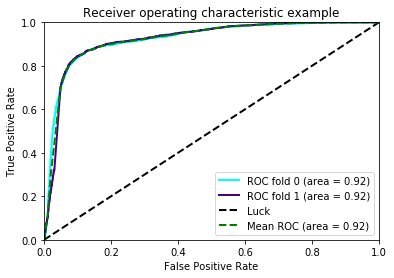

In [13]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Split samples to 2.
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
# Early stopping conditions.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y_trans), colors):
    conv_model = build_conv_model()
    # Train the model and get traning history
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), 
                             nb_epoch=100, batch_size=256, verbose=0, callbacks=[early_stopping])
    # Get prediction probability for test samples
    Y_score = conv_model.predict_proba(X[test])[:, 1]
    # Record the histories
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y_trans[test], Y_score)
    # One-dimensional linear interpolation
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    _=plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
_=plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
# Plot the average ROC of the K stratified fold (K=2 here)
mean_tpr /= kfold.get_n_splits(X, encoded_Y_trans)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
_=plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
_=plt.xlim([0, 1.0])
_=plt.ylim([0, 1.0])
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('Receiver operating characteristic example')
_=plt.legend(loc="lower right")
_=plt.show()

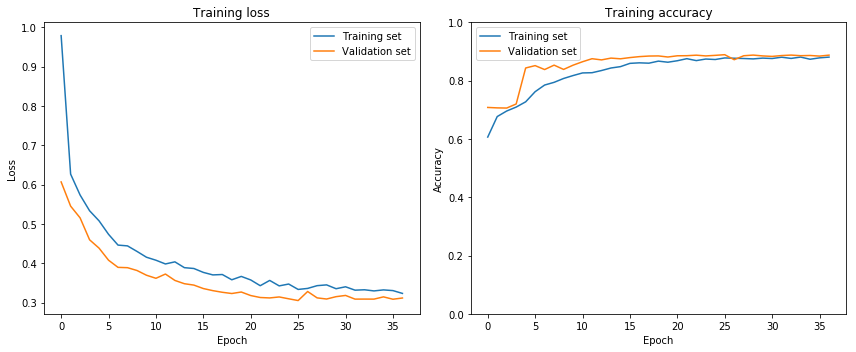

In [14]:
# Plot the evolution of the loss for both training and testing datasets
def draw_train_history(history, draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
# The reason the training loss is higher than validation loss is explained in 
# https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss
# It's because dropout and L1/L2 weights are turned off at validation (testing) and validation is
# computed at the end of the epoch while training loss is the average of the losses over the batches.
draw_train_history(histories[0])